<a href="https://colab.research.google.com/github/fidelis2025/stankelly-website/blob/main/quickstarts/XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Preprocessing

In [2]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Step 1: Upload file manually
from google.colab import files
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

uploaded = files.upload()  # This lets you pick file from your PC
file_path = list(uploaded.keys())[0]  # Automatically use uploaded filename

# Step 2: Read dataset
data = pd.read_csv(file_path)
print("Original Data (first 5 rows):")
print(data.head())

Saving water_potability.csv to water_potability.csv
Original Data (first 5 rows):
         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  


In [7]:
# Step 1: Import libraries
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Step 2: Read dataset (already uploaded via files.upload())
file_path = "water_potability.csv"
data = pd.read_csv(file_path)

# Preview the dataset
print("Original Data (first 5 rows):")
print(data.head())

# Step 3: Mean imputation for missing values
imputer = SimpleImputer(strategy='mean')
imputed_data = imputer.fit_transform(data)

# Convert back to DataFrame with original column names
imputed_df = pd.DataFrame(imputed_data, columns=data.columns)

print("\nData after Mean Imputation (first 5 rows):")
print(imputed_df.head())

# Step 4: Separate features and target (Potability)
X = imputed_df.drop("Potability", axis=1)  # Features
y = imputed_df["Potability"]               # Target

# Step 5: Normalize only the features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Convert back to DataFrame
X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)

# Step 6: Recombine features and target
final_data = pd.concat([X_normalized_df, y.reset_index(drop=True)], axis=1)

print("\nFinal Dataset after Imputation & Normalization (first 5 rows):")
print(final_data.head())

Original Data (first 5 rows):
         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  

Data after Mean Imputation (first 5 rows):
         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0  7.

XAI Analysis

In [10]:
# ============================================
# Step 1: Import required libraries
# ============================================
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, precision_recall_curve, auc, brier_score_loss
)
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================
# Step 2: Load and preprocess dataset
# ============================================
file_path = "water_potability.csv"
data = pd.read_csv(file_path)

# Handle missing values (mean imputation)
imputer = SimpleImputer(strategy='mean')
imputed_data = imputer.fit_transform(data)
imputed_df = pd.DataFrame(imputed_data, columns=data.columns)

# Separate features and target
X = imputed_df.drop("Potability", axis=1)
y = imputed_df["Potability"]

# Normalize features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)

# Final dataset
final_data = pd.concat([X_normalized_df, y.reset_index(drop=True)], axis=1)

print("Final Data Sample:")
print(final_data.head())

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized_df, y, test_size=0.2, random_state=42, stratify=y
)

Final Data Sample:
         ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
0  0.505771  0.571139  0.336096     0.543891  0.680385      0.669439   
1  0.265434  0.297400  0.300611     0.491839  0.581699      0.719411   
2  0.578509  0.641311  0.321619     0.698543  0.581699      0.414652   
3  0.594055  0.605536  0.356244     0.603314  0.647347      0.317880   
4  0.649445  0.484851  0.289922     0.484900  0.514545      0.379337   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0        0.313402         0.699753   0.286091         0.0  
1        0.497319         0.450999   0.576793         0.0  
2        0.562017         0.532866   0.303637         0.0  
3        0.622089         0.808065   0.601015         0.0  
4        0.358555         0.253606   0.496327         0.0  


Objective i: Apply XAI (SHAP & LIME)

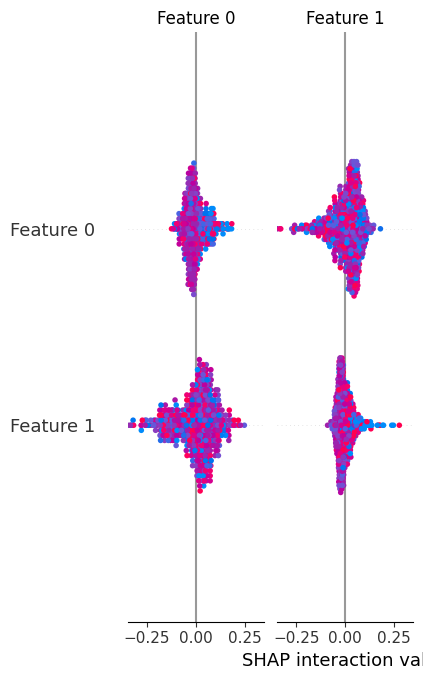

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [14]:
# ============================================
# SHAP and LIME Explanations
# ============================================

# Train a baseline Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# --- SHAP Values ---
explainer_shap = shap.TreeExplainer(rf_model)
shap_values = explainer_shap.shap_values(X_test)

# SHAP summary plot
# If binary classification, try:
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X_test.values, plot_type="bar")
else:
    shap.summary_plot(shap_values, X_test.values, plot_type="bar")

# --- LIME Explanations ---
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns,
    class_names=["Not Potable", "Potable"],
    mode="classification"
)

# Explain a single instance
i = 5
exp = lime_explainer.explain_instance(
    X_test.iloc[i].values,
    rf_model.predict_proba,
    num_features=5
)
exp.show_in_notebook(show_all=False)


Objective ii: Evaluate predictive performance of models

In [15]:
# ============================================
# Model Training and Evaluation (LogReg, RF, XGB)
# ============================================

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results[name] = {
        "AUC-ROC": roc_auc_score(y_test, y_prob),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "Brier Score": brier_score_loss(y_test, y_prob),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

# Print results
for name, metrics in results.items():
    print(f"\n{name} Results:")
    for m, val in metrics.items():
        print(f"{m}: {val}")

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:16:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Logistic Regression Results:
AUC-ROC: 0.5482910156249999
Accuracy: 0.6097560975609756
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Brier Score: 0.23663244949268628
Confusion Matrix: [[400   0]
 [256   0]]

Random Forest Results:
AUC-ROC: 0.6548388671875001
Accuracy: 0.6554878048780488
Precision: 0.6171875
Recall: 0.30859375
F1-score: 0.4114583333333333
Brier Score: 0.21651764481707317
Confusion Matrix: [[351  49]
 [177  79]]

XGBoost Results:
AUC-ROC: 0.61103515625
Accuracy: 0.6295731707317073
Precision: 0.5371428571428571
Recall: 0.3671875
F1-score: 0.4361948955916473
Brier Score: 0.2555890955290326
Confusion Matrix: [[319  81]
 [162  94]]


Stratified 5-Fold CV with Nested Hyperparameter Tuning

In [17]:
# ============================================
# Stratified 5-Fold CV with Nested Hyperparameter Tuning
# ============================================

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, brier_score_loss, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np
import pandas as pd

# Define outer 5-fold CV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models and their hyperparameter grids
param_grids = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, solver="liblinear"),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "penalty": ["l1", "l2"]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [None, 5, 10],
            "min_samples_split": [2, 5]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.2]
        }
    }
}

results = {}

# Loop through models
for name, mp in param_grids.items():
    print(f"\nRunning model: {name}")
    model = mp["model"]
    param_grid = mp["params"]

    # Inner CV for hyperparameter tuning
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=inner_cv, scoring="roc_auc", n_jobs=-1)

    # Get cross-validated predictions using outer CV
    y_pred = cross_val_predict(grid_search, X, y, cv=outer_cv, method="predict")
    y_prob = cross_val_predict(grid_search, X, y, cv=outer_cv, method="predict_proba")[:, 1]

    # Store metrics
    results[name] = {
        "AUC-ROC": roc_auc_score(y, y_prob),
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "F1-score": f1_score(y, y_pred),
        "Brier Score": brier_score_loss(y, y_prob),
        "Confusion Matrix": confusion_matrix(y, y_pred)
    }

# Print results
for name, metrics in results.items():
    print(f"\n{name} Results (Stratified 5-fold CV with nested tuning):")
    for m, val in metrics.items():
        print(f"{m}: {val}")


Running model: Logistic Regression

Running model: Random Forest

Running model: XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:40:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:41:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:41:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:41:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:41:44] WARNING: /w


Logistic Regression Results (Stratified 5-fold CV with nested tuning):
AUC-ROC: 0.5013178280001441
Accuracy: 0.6092796092796092
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Brier Score: 0.23835386830782251
Confusion Matrix: [[1996    2]
 [1278    0]]

Random Forest Results (Stratified 5-fold CV with nested tuning):
AUC-ROC: 0.6817018505203167
Accuracy: 0.6776556776556777
Precision: 0.6813725490196079
Recall: 0.32629107981220656
F1-score: 0.44126984126984126
Brier Score: 0.21197344095498596
Confusion Matrix: [[1803  195]
 [ 861  417]]

XGBoost Results (Stratified 5-fold CV with nested tuning):
AUC-ROC: 0.6687912482122185
Accuracy: 0.6617826617826618
Precision: 0.6319875776397516
Recall: 0.31846635367762127
F1-score: 0.42351716961498437
Brier Score: 0.2147761420956428
Confusion Matrix: [[1761  237]
 [ 871  407]]


Objective iii: Ethical & actionable insights for policymakers


Top Features Driving Water Potability Decisions:
           Feature  Importance
4          Sulfate    0.128893
0               ph    0.128830
1         Hardness    0.119528
3      Chloramines    0.115018
2           Solids    0.113079
5     Conductivity    0.101051
8        Turbidity    0.099487
6   Organic_carbon    0.097910
7  Trihalomethanes    0.096203


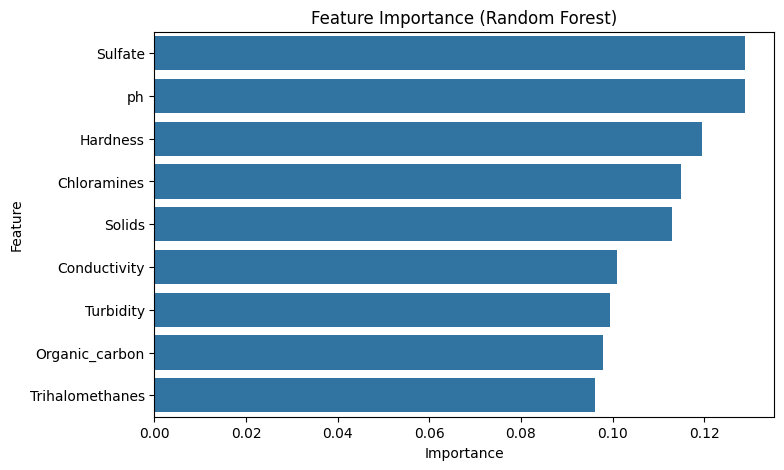

In [16]:
# ============================================
# Translate Feature Importance into Insights
# ============================================

# Feature importance from Random Forest
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nTop Features Driving Water Potability Decisions:")
print(feature_importance_df)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importance (Random Forest)")
plt.show()

In [24]:
!pip install lime


Top Features Driving Water Potability Decisions (Random Forest):
           Feature  RF_Importance
0          Sulfate       0.129219
1               ph       0.128316
2         Hardness       0.121963
3      Chloramines       0.114038
4           Solids       0.112807
5     Conductivity       0.101923
6   Organic_carbon       0.098481
7        Turbidity       0.098004
8  Trihalomethanes       0.095249


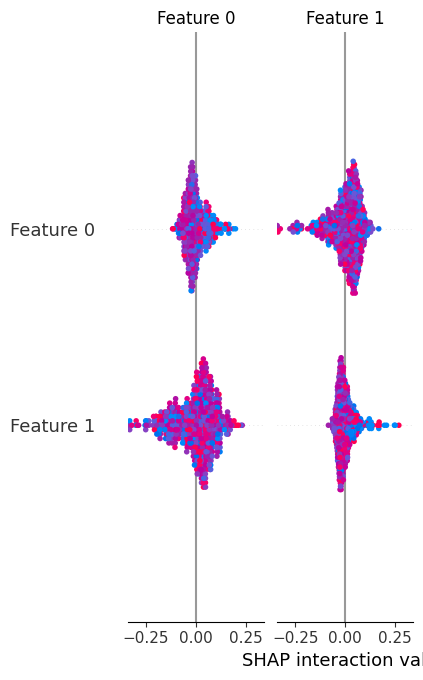

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local


Combined Feature Importances (top 10):
           Feature  RF_Importance  SHAP_Importance  Perm_Importance  \
0          Sulfate       0.129219         0.048516         0.063161   
1               ph       0.128316         0.039191         0.032419   
2         Hardness       0.121963         0.030625         0.021697   
3      Chloramines       0.114038         0.022205         0.022358   
4           Solids       0.112807         0.022026         0.011230   
5     Conductivity       0.101923         0.018464        -0.012043   
6   Organic_carbon       0.098481         0.012431        -0.007774   
7        Turbidity       0.098004         0.011732        -0.017683   
8  Trihalomethanes       0.095249         0.013359        -0.004827   

   LIME_Importance  
0         0.055585  
1         0.031955  
2         0.022560  
3         0.021909  
4         0.010602  
5         0.014460  
6         0.005194  
7         0.004062  
8         0.007236  

To assess robustness, Spearman rank co

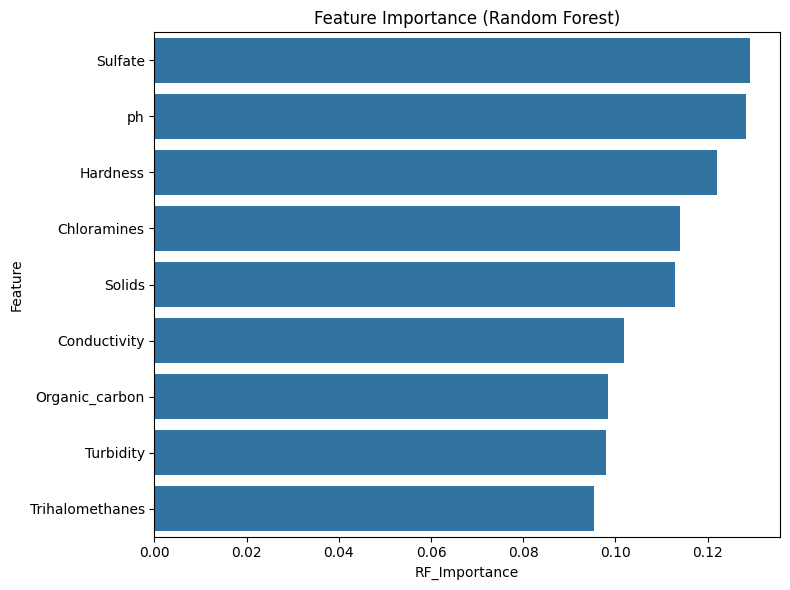

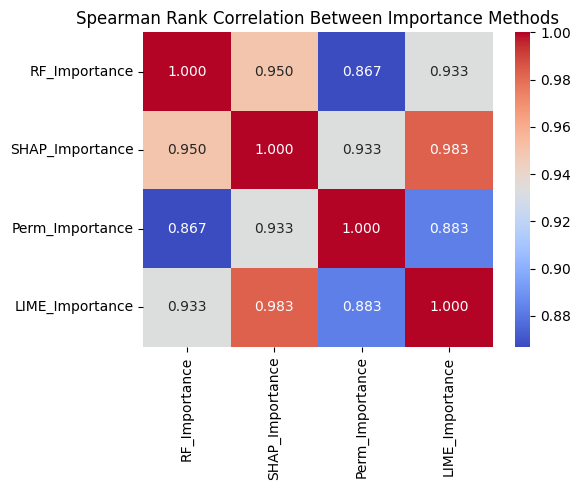


Example correct prediction index: 1
Example incorrect prediction index: 0

LIME explanation for a correct prediction (first example):


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[('0.53 < Sulfate <= 0.58', -0.0611842907210937),
 ('ph <= 0.45', -0.04569659399477592),
 ('0.47 < Hardness <= 0.54', -0.024756589120944902),
 ('Organic_carbon > 0.55', 0.016718127608382503),
 ('0.43 < Conductivity <= 0.53', -0.01545155552506255)]


LIME explanation for an incorrect prediction (first example):


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[('0.53 < Sulfate <= 0.58', -0.057467558129275176),
 ('0.47 < Hardness <= 0.54', -0.03267628190127755),
 ('0.45 < ph <= 0.51', 0.028425406830193404),
 ('0.46 < Organic_carbon <= 0.55', -0.014387072767229952),
 ('Trihalomethanes > 0.61', 0.012866616389130657)]

In [33]:
# Combined pipeline: RF, SHAP, LIME, Permutation importance, Spearman rank correlations
# Assumes: X_train, X_test, y_train, y_test, X are defined (X contains full features and columns)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr

import shap
import lime
import lime.lime_tabular

# ---------------------------
# 1) Train Random Forest
# ---------------------------
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# ---------------------------
# 2) Random Forest importances
# ---------------------------
rf_importances = rf_model.feature_importances_
rf_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "RF_Importance": rf_importances
}).sort_values(by="RF_Importance", ascending=False).reset_index(drop=True)

print("\nTop Features Driving Water Potability Decisions (Random Forest):")
print(rf_importance_df.head(10))

# ---------------------------
# --- SHAP feature importances robust handling ---
if isinstance(shap_values, list):
    # For binary classification: take the array for the positive class (class 1)
    shap_used = shap_values[1]
else:
    shap_used = shap_values

# Compute mean absolute SHAP per feature -> should be 1D
shap_importances = np.abs(shap_used).mean(axis=0)

# If it's more than 1D, flatten
if shap_importances.ndim > 1:
    shap_importances = shap_importances.mean(axis=tuple(range(1, shap_importances.ndim)))

# Make sure it's 1D
shap_importances = np.ravel(shap_importances)

# Align length with number of features
n_features = X.shape[1]
if shap_importances.shape[0] != n_features:
    if shap_importances.shape[0] == n_features + 1:
        shap_importances = shap_importances[1:]  # drop bias term
    else:
        raise ValueError(f"SHAP importances length ({shap_importances.shape[0]}) "
                         f"does not match number of features ({n_features}).")

# Final dataframe
shap_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "SHAP_Importance": shap_importances
}).sort_values(by="SHAP_Importance", ascending=False).reset_index(drop=True)


# SHAP summary plot (global, bar)
# Use the same robust handling used earlier for plotting
if isinstance(shap_values, list):
    try:
        shap.summary_plot(shap_values[1], X_test.values, plot_type="bar", show=True)
    except Exception:
        # fallback: use shap_used which is already aligned
        shap.summary_plot(shap_used, X_test.values, plot_type="bar", show=True)
else:
    shap.summary_plot(shap_used, X_test.values, plot_type="bar", show=True)

# ---------------------------
# 4) Permutation importance
# ---------------------------
perm_result = permutation_importance(rf_model, X_test, y_test, n_repeats=30, random_state=42)
perm_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Perm_Importance": perm_result.importances_mean
}).sort_values(by="Perm_Importance", ascending=False).reset_index(drop=True)

# ---------------------------
# 5) LIME: aggregate local importance into a global measure
# ---------------------------
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=list(X.columns),
    class_names=[str(c) for c in rf_model.classes_],
    mode="classification"
)

# Choose up to m instances from X_test to explain (random sample for stability)
m = min(50, len(X_test))
rng = np.random.RandomState(42)
sample_idxs = rng.choice(np.arange(len(X_test)), size=m, replace=False)

# For each explained instance, get weights for all features; if a feature is absent in the explanation, weight=0
lime_weights = np.zeros((m, n_features))

for idx_i, instance_idx in enumerate(sample_idxs):
    try:
        exp = lime_explainer.explain_instance(
            X_test.iloc[instance_idx].values,
            rf_model.predict_proba,
            num_features=n_features
        )
        # exp.as_list() returns list of (feature_name, weight) strings; convert to dict
        # Note: feature names in the LIME output might include thresholds like "pH <= 7.2". We map by column presence.
        exp_list = exp.as_list(label=1) if 1 in rf_model.classes_ else exp.as_list()
        # Build a dict of exact feature names if possible, otherwise try to parse
        weight_dict = {}
        for feat_name, weight in exp_list:
            # Try to match the feature by checking if column name is substring of feat_name
            matched = [c for c in X.columns if c in feat_name]
            if len(matched) == 1:
                weight_dict[matched[0]] = weight
            elif len(matched) > 1:
                # ambiguous, pick the exact match or first hit
                exact = [c for c in matched if feat_name.strip().startswith(c)]
                weight_dict[exact[0] if exact else matched[0]] = weight
            else:
                # fallback: try split at space or '=' and match
                token = feat_name.split()[0].split('=')[0].strip()
                if token in X.columns:
                    weight_dict[token] = weight
                # else ignore this explanation term
        # Fill weights row for this instance
        lime_weights[idx_i, :] = [abs(weight_dict.get(f, 0.0)) for f in X.columns]
    except Exception as e:
        # If LIME fails on a particular instance, leave row as zeros and continue
        print(f"Warning: LIME failed for test instance {instance_idx}: {e}")
        continue

# Average absolute LIME weights across explained instances
lime_importances = np.mean(lime_weights, axis=0)
lime_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "LIME_Importance": lime_importances
}).sort_values(by="LIME_Importance", ascending=False).reset_index(drop=True)

# ---------------------------
# 6) Merge all importances and compute Spearman rank correlations
# ---------------------------
all_importances = rf_importance_df.merge(shap_importance_df, on="Feature") \
                                  .merge(perm_importance_df, on="Feature") \
                                  .merge(lime_importance_df, on="Feature")

# Print combined table
print("\nCombined Feature Importances (top 10):")
print(all_importances.sort_values(by="RF_Importance", ascending=False).head(10))

# Compute Spearman rank correlations between methods
methods = ["RF_Importance", "SHAP_Importance", "Perm_Importance", "LIME_Importance"]
rank_corr = pd.DataFrame(index=methods, columns=methods, dtype=float)

for m1 in methods:
    for m2 in methods:
        rho, pval = spearmanr(all_importances[m1], all_importances[m2])
        rank_corr.loc[m1, m2] = round(rho, 3)

print("\nTo assess robustness, Spearman rank correlations were calculated between feature rankings obtained from SHAP, LIME, and permutation methods. Discrepancies were analyzed to highlight the influence of nonlinearities and feature interactions.")
print("\nSpearman Rank Correlations Between Feature Ranking Methods:")
print(rank_corr)

# ---------------------------
# 7) Visualizations (optional)
# ---------------------------

# RF barplot
plt.figure(figsize=(8, 6))
sns.barplot(x="RF_Importance", y="Feature", data=rf_importance_df)
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(rank_corr.astype(float), annot=True, fmt=".3f", cmap="coolwarm", cbar=True)
plt.title("Spearman Rank Correlation Between Importance Methods")
plt.tight_layout()
plt.show()

# ---------------------------
# 8) LIME local examples: correct vs incorrect predictions indices
# ---------------------------
# find first correct and incorrect prediction indices (if exist)
y_pred = rf_model.predict(X_test)
correct_idxs = np.where(y_test.values == y_pred)[0]
incorrect_idxs = np.where(y_test.values != y_pred)[0]

correct_idx = int(correct_idxs[0]) if len(correct_idxs) > 0 else None
incorrect_idx = int(incorrect_idxs[0]) if len(incorrect_idxs) > 0 else None

print(f"\nExample correct prediction index: {correct_idx}")
print(f"Example incorrect prediction index: {incorrect_idx}")

if correct_idx is not None:
    print("\nLIME explanation for a correct prediction (first example):")
    display(lime_explainer.explain_instance(X_test.iloc[correct_idx].values, rf_model.predict_proba, num_features=5).as_list())

if incorrect_idx is not None:
    print("\nLIME explanation for an incorrect prediction (first example):")
    display(lime_explainer.explain_instance(X_test.iloc[incorrect_idx].values, rf_model.predict_proba, num_features=5).as_list())

Objective iv: Role of Interpretable AI in SDG 6

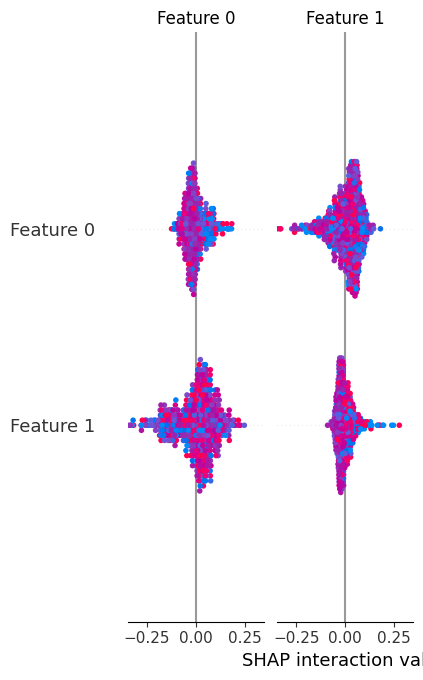


Correctly Classified Instance Explanation:


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



Incorrectly Classified Instance Explanation:


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [19]:
# ============================================
# Demonstrate interpretability for sustainable decision-making
# ============================================

# ============================================
# Demonstrate interpretability for sustainable decision-making
# ============================================

# --- SHAP global feature ranking ---
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X_test.values, plot_type="bar")
else:
    shap.summary_plot(shap_values, X_test.values, plot_type="bar")

# --- LIME Local explanations ---
correct_idx = np.where(y_test.values == rf_model.predict(X_test))[0][0]
incorrect_idx = np.where(y_test.values != rf_model.predict(X_test))[0][0]

print("\nCorrectly Classified Instance Explanation:")
lime_explainer.explain_instance(
    X_test.iloc[correct_idx].values,
    rf_model.predict_proba,
    num_features=5
).show_in_notebook()

print("\nIncorrectly Classified Instance Explanation:")
lime_explainer.explain_instance(
    X_test.iloc[incorrect_idx].values,
    rf_model.predict_proba,
    num_features=5
).show_in_notebook()